<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.
* Métodos de *kernel*.
* Extracción de características.
* Múltiples anotaciones

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de discusión y entrega: 8 de Noviembre.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF393-II-2018]

<hr style="height:2px;border:none"/>

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Sentiment Analysis en Texto  
[2.](#segundo) pendiente


<a id="primero"></a>
## 1. Sentiment Analysis en Texto

El análisis de emociones o sentimientos se refiere al proceso de extraer información acerca de la actitud
que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con respecto a un
tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar la polaridad
de un trozo de texto, es decir, clasificar una determinada evaluación escrita (*review*), en que una persona
manifiesta una opinión, como *positiva*, *negativa* o *neutral*. Esto también ha sido extendido a otros medios, como lo es analizar la polaridad de textos en redes sociales.  La dificultad de este problema radica en el carácter altamente ambiguo e informal del lenguaje que utilizan naturalmente las personas ası́ como el manejo de negaciones, sarcasmo y abreviaciones en una frase.

<img src="https://formtitanhelpdeskimage.s3.amazonaws.com/70c78f9df2fd5c130e7021644f78f4c5.jpg" title="Title text" width="40%" />


Los datos que usaremos para esta actividad corresponden a un subconjunto de los datos publicados en **Kaggle**,  en  el  contexto  de  una  competencia  organizada  por  la  Universidad  de  Stanford  [[2]](#refs).   Cada  registro disponible corresponderá a una opinión sobre una película, registrada sobre el sitio *Rotten Tomatoes*.  Para empezar  nos  limitaremos  a  estudiar  textos  anotados  como  positivos  o  negativos,  clases  que  codificaremos como +1 y 0 respectivamente. Los datos pueden ser descargados ejecutando el siguiente código en sistema Unix:
```
wget -O train_data.csv http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train
wget -O test_data.csv http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev
```

> Cargue los dos conjuntos de datos a ser trabajados, donde la etiqueta ya viene codificada y la dejaremos como negativo (0) y positivo (1).

In [13]:
import pandas as pd

ftr = open("train_data.csv", "r",  encoding="ISO-8859-1")
rows = [line.split(" ",1) for line in ftr.readlines()]
df_train = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_train['Sentiment'] = (pd.to_numeric(df_train['Sentiment'])+1)/2   # 0 o 1

fts = open("test_data.csv", "r",  encoding="ISO-8859-1")
rowstest = [line.split(" ",1) for line in fts.readlines()]
df_test = pd.DataFrame(rowstest, columns=['Sentiment','Text'])
df_test['Sentiment'] = (pd.to_numeric(df_test['Sentiment'])+1)/2    # 0 o 1

... #same loading for test

df_train_text = df_train.Text
df_test_text = df_test.Text
labels_train = df_train.Sentiment.values
labels_test = df_test.Sentiment.values 



> a) Describa los datos trabajados, como la cantidad de datos en cada conjunto, largo de los textos, la cantidad de ejemplo por cada clase, o alguna otra forma que piense que pueda ser útil para comprender el problema trabajado.

In [14]:
df_train.Sentiment.shape
df_test.Sentiment.shape

(3554,)

**df_train:** datos (3554, 2). 

**df_test:** datos (3554, 2).

**labels_train:** etiquetas (1, 3554).

**labels_test:** etiquetas (1, 3554).

> b) Construya un conjunto de validación desde el conjunto de entrenamiento para seleccionar modelos. Decida el tamaño dada la cantidad de ejemplos que se tienen para entrenamiento.

In [15]:
from sklearn.model_selection import train_test_split

choosesizeb = 1184
df_train_text, df_val_text, labels_train, labels_val  = train_test_split(df_train_text, labels_train, test_size = choosesizeb, random_state=0)

print(df_train_text.shape, df_val_text.shape, labels_train.shape, labels_val.shape)


(2370,) (1184,) (2370,) (1184,)


La variable choosesizeb es con la que se elige el tamaño para el conjunto de validación. La elección es 1184 correspondiente a un tercio del total de datos.

> c) Realice un pre-procesamiento a los textos para normalizar un poco su estructura, para ello utilice el código de ejemplo a continuación, donde se pasa el texto a minúsculas (*lower-casing*), se reducen las mútliples letras, se eliminan palabras sin significados como artículos, pronombres y preposiciones (*stop word removal* [[3]](#refs)), además de pasar las palabras a su tronco léxico con la técnica de *lemmatizer* [[4]](#refs). Comente la importancia de un correcto pre-procesamiento en el domino de lenguaje natural.

In [16]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize

def base_word(word):
    wordlemmatizer = WordNetLemmatizer()
    return wordlemmatizer.lemmatize(word) 
def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1', text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words
... #try yourself
word_extractor("I love to eat cake")
word_extractor("I love eating cake")
word_extractor("I loved eating the cake")
word_extractor("I do not love eating cake")
word_extractor("I don't love eating cake")
... #try yourself
texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]

La función word_extractor cumple el rol de eliminar las palabras que son inútiles, ya que no entregan ningún contenido relevante a la sentencia. Aquí una lista de palabras comunes que se eliminan con este método: https://gist.github.com/sebleier/554280. Además de discriminar las palabras útiles e inútiles, ayuda a utilizar menos recursos del computador.

> d) Construya una representación vectorial a los textos de entrada para poder ser manejados y clasificados por los modelos de aprendizaje. Para ésto utilice el tipo de característica más común, que consiste en contar cuántas veces aparece cada términos/palabras en el texto, denominado **TF** (*term-frequency*). Para esto, se necesita contar con un vocabulario base, el cual se construirá a través de la unión de todas las palabras que observemos en los textos de entrenamiento ¿Cuáles son las palabras más frecuentes?

Se utiliza term-frequency

In [17]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizer.fit(texts_train)

... #conjunto entrenamiento
features_train = vectorizer.transform(texts_train) 

vocab = vectorizer.get_feature_names()
dist_train = list(np.array(features_train.sum(axis=0)).reshape(-1,))

#transform val and test

... #conjunto validación
features_val = vectorizer.transform(texts_val)
dist_val = list(np.array(features_val.sum(axis=0)).reshape(-1,))
... #conjunto test
features_test = vectorizer.transform(texts_test)
dist_test = list(np.array(features_test.sum(axis=0)).reshape(-1,))

Se dan a conocer las 10 palabras más frecuentes para cada conjunto, de mayor a menor.

In [18]:
...#train set
palmasfrectrain = np.argsort(np.array(dist_train))[-10:]

listpalmasfrectrain = []
for i in palmasfrectrain:
    listpalmasfrectrain.append(vocab[i])
    
print("conjunto entrenamiento: ", listpalmasfrectrain[::-1])

...#validation set
palmasfrecval = np.argsort(np.array(dist_val))[-10:]

listpalmasfrecval = []
for i in palmasfrecval:
    listpalmasfrecval.append(vocab[i])
    
print("conjunto validación: ", listpalmasfrecval[::-1])

...#test set
palmasfrectest = np.argsort(np.array(dist_test))[-10:]

listpalmasfrectest = []
for i in palmasfrectest:
    listpalmasfrectest.append(vocab[i])
    
print("conjunto test: ", listpalmasfrectest[::-1])

conjunto entrenamiento:  ['film', 'movie', 'one', 'ha', 'like', 'make', 'story', 'character', 'even', 'good']
conjunto validación:  ['film', 'movie', 'like', 'one', 'ha', 'time', 'story', 'comedy', 'good', 'doe']
conjunto test:  ['film', 'movie', 'one', 'ha', 'like', 'story', 'character', 'time', 'make', 'good']


> e) Para tener una visión distinta y entender mejor la representación vectorial realizada, visualice los datos en un plano 2D. Para ésto utilice la técnica **LSA** (*Latent Semantic Analysis*) [[5]](#refs) que a diferencia de PCA, **no centra** los datos antes de realizar la descomposicipon SVD, de ésta manera podrá visualizar el espacio semántico de "conceptos" latentes usados en la representación. Coloree cada texto en base a su clase ¿Qué indica lo observado? Comente e interprete los resultados

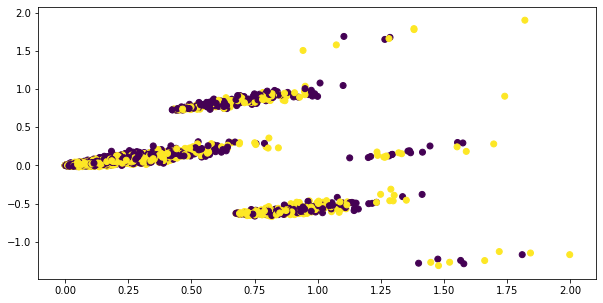

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

model = TruncatedSVD(n_components = 2)
model.fit(features_train)
x_plot = model.transform(features_train)
plt.figure(figsize=(10,5))
plt.scatter(x_plot[:,0], x_plot[:,1], c = labels_train)
plt.show()

Indica que hay tres agrupaciones importantes a los que pertenecen todas las palabras. Se evidencian pocos outliers con respecto al total de datos.

> f) Entrene un modelo de Regresión Logística Regularizado (utilizando como penalizador la norma $l_2$). Varíe el parámetro de regularización $C$, en potencias de 10, midiendo el error de predicción obtenido sobre los datos de entrenamiento y validación, construya un gráfico que muestre la variación de ambos errores respecto al parámetro $C$. Explique el significado y valor esperado del parámetro de regularización.

Param C=  0.0001
Param C=  0.001
Param C=  0.01
Param C=  0.1
Param C=  1
Param C=  10
Param C=  100
Param C=  1000
[0.4966216216216216, 0.5641891891891891, 0.6554054054054054, 0.7069256756756757, 0.7094594594594594, 0.7069256756756757, 0.6959459459459459, 0.6951013513513513]


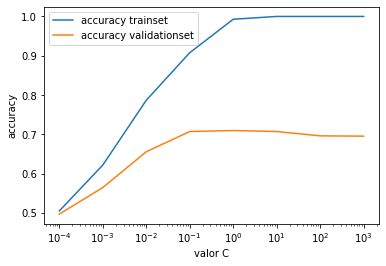

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [20]:
from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xv,yv, param):
    print("Param C= ",param)
    model= LogisticRegression()
    model.set_params(C=param,max_iter = 10000)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
#Cs = [10**i for i in np.arange(-4,4)]
#model, train_acc, test_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = 10)

listCvalores = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
acc_train = []
acc_val =  []
for i in listCvalores:
    model, train_acc, val_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = i)
    acc_train.append(train_acc)
    acc_val.append(val_acc)

print(acc_val)
plt.plot(listCvalores,acc_train,label = 'accuracy trainset')
plt.plot(listCvalores,acc_val,label = 'accuracy validationset')
plt.xlabel('valor C')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend()
plt.show()
print(model)
    
    
    

El parámetro de regulación $C$ corresponde al dato que se ingresa para reducir el overfitting. A medida que el valor es más pequeño, mayor es la regularización. De esta manera, a medida que C aumenta, se ajusta con mayor precisión a los datos de entrenamiento, como se aprecia en los gráficos.

> g) Entrene una Máquina de Soporte Vectorial (SVM) con distintos kernels. Similar a lo anterior, construya un gráfico que muestre la variación de ambos errores respecto al parámetro de regularización $C$ para cada tipo de kernel que experimente. Explique el significado y valor esperado de los parámetros en este modelo.

Param C=  0.0001 Kernel=  linear
Param C=  0.001 Kernel=  linear
Param C=  0.01 Kernel=  linear
Param C=  0.1 Kernel=  linear
Param C=  1 Kernel=  linear
Param C=  10 Kernel=  linear
Param C=  100 Kernel=  linear
Param C=  1000 Kernel=  linear
[0.4966216216216216, 0.4966216216216216, 0.6072635135135135, 0.6967905405405406, 0.691722972972973, 0.6883445945945946, 0.6883445945945946, 0.6883445945945946]


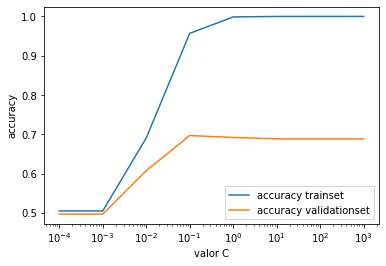

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Param C=  0.0001 Kernel=  rbf
Param C=  0.001 Kernel=  rbf
Param C=  0.01 Kernel=  rbf
Param C=  0.1 Kernel=  rbf
Param C=  1 Kernel=  rbf
Param C=  10 Kernel=  rbf
Param C=  100 Kernel=  rbf
Param C=  1000 Kernel=  rbf
[0.4966216216216216, 0.4966216216216216, 0.4966216216216216, 0.49746621621621623, 0.6891891891891891, 0.6908783783783784, 0.6925675675675675, 0.6925675675675675]


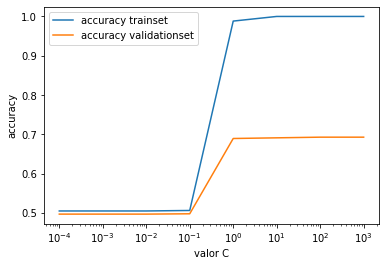

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Param C=  0.0001 Kernel=  poly
Param C=  0.001 Kernel=  poly
Param C=  0.01 Kernel=  poly
Param C=  0.1 Kernel=  poly
Param C=  1 Kernel=  poly
Param C=  10 Kernel=  poly
Param C=  100 Kernel=  poly
Param C=  1000 Kernel=  poly
[0.4966216216216216, 0.4966216216216216, 0.4966216216216216, 0.4966216216216216, 0.6461148648648649, 0.6621621621621622, 0.6089527027027027, 0.6114864864864865]


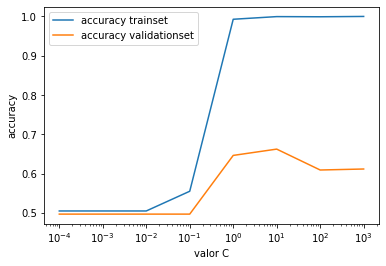

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Param C=  0.0001 Kernel=  sigmoid
Param C=  0.001 Kernel=  sigmoid
Param C=  0.01 Kernel=  sigmoid
Param C=  0.1 Kernel=  sigmoid
Param C=  1 Kernel=  sigmoid
Param C=  10 Kernel=  sigmoid
Param C=  100 Kernel=  sigmoid
Param C=  1000 Kernel=  sigmoid
[0.4966216216216216, 0.4966216216216216, 0.4966216216216216, 0.5827702702702703, 0.6984797297297297, 0.6815878378378378, 0.6579391891891891, 0.6663851351351351]


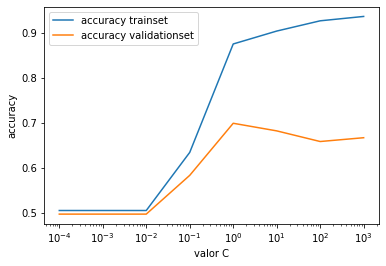

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [21]:
from sklearn.svm import SVC as SVM #SVC is for classification
def do_SVM(x,y,xv,yv, param, kernel='linear'):
    print("Param C= ",param, 'Kernel= ', kernel)
    modelsvm= SVM(probability = True)
    modelsvm.set_params(C=param,kernel=kernel) #try rbf and linear at least
    modelsvm.fit(x,y)
    train_acc = modelsvm.score(x,y)
    test_acc = modelsvm.score(xv,yv)
    return modelsvm, train_acc, test_acc
Cs = [10**int(i) for i in np.arange(-4,4)]


listCvalores = ['linear', 'rbf', 'poly', 'sigmoid']

for i in listCvalores:
    acc_train = []
    acc_val =  []
    for j in Cs:
        modelsvm, train_acc, val_acc = do_SVM(features_train, labels_train, features_val, labels_val, j, i)
        acc_train.append(train_acc)
        acc_val.append(val_acc)
    print(acc_val)
    plt.plot(Cs,acc_train,label = 'accuracy trainset')
    plt.plot(Cs,acc_val,label = 'accuracy validationset')
    plt.xlabel('valor C')
    plt.ylabel('accuracy')
    plt.xscale('log')
    plt.legend()
    plt.show()
    print(modelsvm)

    

Se aprecia que la variación del parámetro $C$ efectivamente es relevante para con la accuracy del modelo.

> h) Utilice el algoritmo de similaridad k-NN para intentar resolver el problema. Varíe el parámetro de los vecinos $k$ en un rango que estime conveniente y realice graficos de errores como en las preguntas anteriores. Comente sobre el valor esperado de este parámetro.

Param K=  1
Param K=  301
Param K=  601
Param K=  901
Param K=  1201
Param K=  1501
Param K=  1801
Param K=  2101
[0.5692567567567568, 0.5599662162162162, 0.5768581081081081, 0.5658783783783784, 0.535472972972973, 0.5515202702702703, 0.5363175675675675, 0.4966216216216216]


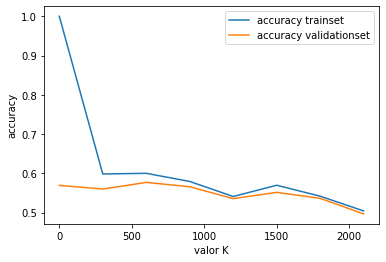

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2101, p=2,
                     weights='uniform')


In [22]:
from sklearn.neighbors import KNeighborsClassifier
def do_KNN(x,y,xv,yv, param):
    model = KNeighborsClassifier()
    print("Param K= ",param)
    model.set_params(n_neighbors=param)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
steps = 300
Ks = np.arange(1, features_train.shape[0], steps)
acc_train = []
acc_val =  []
for i in Ks:
    model, train_acc, val_acc = do_KNN(features_train, labels_train, features_val, labels_val, param = i)
    acc_train.append(train_acc)
    acc_val.append(val_acc)
print(acc_val)
plt.plot(Ks,acc_train,label = 'accuracy trainset')
plt.plot(Ks,acc_val,label = 'accuracy validationset')
plt.xlabel('valor K')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print(model)    

En este modelo, al aumentar el valor $K$ se ve una disminución de forma constante del accuracy.

> i) Entrene un Arbol de Decisión para resolver el problema. Varíe los parámetros de *max depth* y *min samples split* de manera separada, constuyendo gráficos de error respecto a estos parámetros. *Los valores que se presentan son sugerencias, no es necesario utilizar los mismos*. Comente sobre la diferencia entre la selección de estos dos parámetros.

Param Max-D=  1 Min-samples-S=  2
Param Max-D=  301 Min-samples-S=  2
Param Max-D=  601 Min-samples-S=  2
Param Max-D=  901 Min-samples-S=  2
Param Max-D=  1201 Min-samples-S=  2
Param Max-D=  1501 Min-samples-S=  2
Param Max-D=  1801 Min-samples-S=  2
Param Max-D=  2101 Min-samples-S=  2
Param Max-D=  2401 Min-samples-S=  2
Param Max-D=  2701 Min-samples-S=  2
Param Max-D=  3001 Min-samples-S=  2
Param Max-D=  3301 Min-samples-S=  2
Param Max-D=  3601 Min-samples-S=  2
Param Max-D=  3901 Min-samples-S=  2
Param Max-D=  4201 Min-samples-S=  2
Param Max-D=  4501 Min-samples-S=  2
Param Max-D=  4801 Min-samples-S=  2
Param Max-D=  5101 Min-samples-S=  2
Param Max-D=  5401 Min-samples-S=  2
Param Max-D=  5701 Min-samples-S=  2
Param Max-D=  6001 Min-samples-S=  2
Param Max-D=  6301 Min-samples-S=  2
Param Max-D=  6601 Min-samples-S=  2
Param Max-D=  6901 Min-samples-S=  2
Param Max-D=  7201 Min-samples-S=  2
Param Max-D=  7501 Min-samples-S=  2
[0.5194256756756757, 0.6021959459459459, 0.6

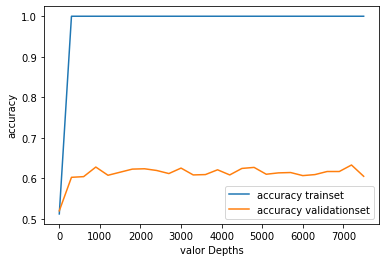

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7501, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Param Max-D=  None Min-samples-S=  2
Param Max-D=  None Min-samples-S=  302
Param Max-D=  None Min-samples-S=  602
Param Max-D=  None Min-samples-S=  902
Param Max-D=  None Min-samples-S=  1202
Param Max-D=  None Min-samples-S=  1502
Param Max-D=  None Min-samples-S=  1802
Param Max-D=  None Min-samples-S=  2102
[0.5996621621621622, 0.6081081081081081, 0.6173986486486487, 0.6114864864864865, 0.5861486486486487, 0.5625, 0.5591216216216216, 0.5202702702702703]


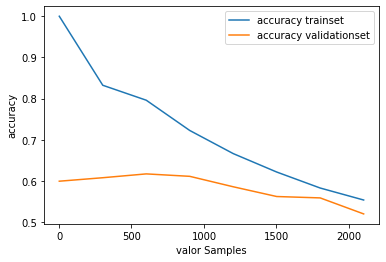

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2102,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [23]:
from sklearn.tree import DecisionTreeClassifier as Tree
def do_Tree(x,y,xv,yv, param_d=None, param_m=2):
    model= Tree()
    print("Param Max-D= ",param_d, 'Min-samples-S= ', param_m)
    model.set_params(max_depth=param_d, min_samples_split=param_m) 
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
steps = 300
Depths = np.arange(1, features_train.shape[1], steps ) #choose steps
SamplesS = np.arange(2, features_train.shape[0] , steps ) #choose steps
acc_train = []
acc_val =  []
for i in Depths:
    model, train_acc, val_acc = do_Tree(features_train, labels_train, features_val, labels_val, i)
    acc_train.append(train_acc)
    acc_val.append(val_acc)
print(acc_val)
plt.plot(Depths,acc_train,label = 'accuracy trainset')
plt.plot(Depths,acc_val,label = 'accuracy validationset')
plt.xlabel('valor Depths')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print(model)   

acc_train = []
acc_val =  []
for i in SamplesS:
    model, train_acc, val_acc = do_Tree(features_train, labels_train, features_val, labels_val, None,i)
    acc_train.append(train_acc)
    acc_val.append(val_acc)
print(acc_val)
plt.plot(SamplesS,acc_train,label = 'accuracy trainset')
plt.plot(SamplesS,acc_val,label = 'accuracy validationset')
plt.xlabel('valor Samples')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print(model)  



A nivel cualitativo, es posible notar que el parámetro Depths se comporta diferente al parámetro Sample. Lo anterior, dado a que el primero mantiene la accuracy mientras él aumenta. Sample, en cambio, disminuye la accuracy cuando él aumenta.

> j) Utilice una Red Neuronal Artificial (ANN) para intentar resolver el problema, como la que se señala a continuación (utilizando el framework de *keras*): entrenada por 25 iteraciones al dataset (*epochs*) con un tamaño de *batch* de 128 para las actualizaciones de los pesos, utilizando *SGD* con una tasa de aprendizaje $0.1$ sobre la función de pérdida binaria de clasificación. La arquitectura de la red contiene una capa de salida con una única neurona que indica la probabilidad de que el texto sea positivo, una capa escondida con número de neuronas $N_h$ y la capa de entrada implícita para $x$. Varíe el parámetro que corresponde al número de neuronas en la capa oculta $N_h$, en potencias de 2, y vuelva a realizar el gráfico de error con respecto al parámetro. Comente.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def do_ANN(x,y, xv,yv, param):
    print("Neuron hidden = ",param)
    model = Sequential()
    model.add(Dense(units=param, input_dim=x.shape[1], activation="sigmoid"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x, y, epochs=25, batch_size=128, verbose=0)
    train_acc = model.evaluate(x,y, verbose=0)[1] #in position 0 is the loss
    test_acc = model.evaluate(xv,yv, verbose=0)[1]
    return model, train_acc, test_acc
N_h = [2**i for i in range(1,10)]

> k) Ahora evalúe sobre el conjunto de pruebas el mejor modelo obtenido, seleccionado en base a la métrica de desempeño en el conjunto de validación. Comente sobre la calidad obtenida en el problema trabajado ¿Es un buen valor? ¿Cuál podría ser un valor de referencia?

Regresión lineal, con parámetro C = 1.

In [24]:
def do_LOGIT(x,y,xv,yv, param):
    print("Param C= ",param)
    model= LogisticRegression()
    model.set_params(C=param,max_iter = 10000)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, test_acc, val_acc
#Cs = [10**i for i in np.arange(-4,4)]
#model, train_acc, test_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = 10)
model, test_acc, val_acc = do_LOGIT(features_test, labels_test, features_val, labels_val, 1)

print(test_acc)

Param C=  1
0.7119932432432432


Es un buen número. Como referencia se puede tomar el accuracy de cada uno de los modelos anteriores en los datos de validación. Este dato obtenido es el mejor número. Un buen número.

> l) Para comparar sus resultados utilice el modelo VADER (*Valence Aware Dictionary and sEntiment Reasoner*) [[6]](#refs), el cual entrega una *score* de predicción a nivel léxico (de palabras que comúnmente se asocian a una orientiación positiva o negativa). Este modelo construido manualmente no requiere entrenamiento, por lo que solo debe evaluar en conjunto de pruebas realizando predicciones del texto bruto (sin pre-procesamiento). Comente.

In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
def vader_predict(sentences): 
    sid_obj = SentimentIntensityAnalyzer() 
    sent_v = []
    for text in sentences:
        sentiment_dict = sid_obj.polarity_scores(text) 
        if sentiment_dict["pos"] > sentiment_dict["neg"]: #based on scores
            sent_v.append(1)
        else:
            sent_v.append(0)
    return np.asarray(sent_v)
vader_pred_test = vader_predict(df_test_text) 
from sklearn.metrics import accuracy_score
accuracy_score(labels_test, vader_pred_test)

0.6359032076533483

El valor entragado por vader_predict corresponde a 0.6359032076533483, el cual es inferior al entregado por la regresión logística con parámetro C = 1 : 0.7119932432432432.

> m) Bajo la idea del modelo VADER realice un análisis de qué palabras su modelo tiende a considerar como positivas o negativas por si solas. Algunos de los modelos estudiados en esta sección realizan una predicción probabilista, utilice uno de éstos para verificar lo solicitado. Sobre la representación *TF* genere datos de entradas que contengan una sola palabra del vocabulario para evaluar que predicción les genera su modelo a esas palabras. Muestre las palabras más negativas y positivas en el vocabulario consideradas por su modelo. Comente.

In [26]:
V = len(vocab)
word_scores = np.zeros((V, 2))
for i in range(V):
    x_word = np.zeros((1, V))
    x_word[:,i] = 1 # only the "i" word appeared
    word_scores[i] = modelsvm.predict_proba(x_word) #se utiliza ultimo modelo definido
    #print(word_scores[i])
    #break
vocab

print(word_scores)
#print(word_scores[:5])

[[0.46681266 0.53318734]
 [0.50936751 0.49063249]
 [0.5        0.5       ]
 ...
 [0.50936751 0.49063249]
 [0.50936751 0.49063249]
 [0.52570571 0.47429429]]


In [27]:
neg_palabra_score = []
pos_palabra_score = []


for i in range(V):
    if word_scores[i][0] >= word_scores[i][1]:
        neg_palabra_score.append((word_scores[i][0], vocab[i])) #palabras negativas
    else:
        pos_palabra_score.append((word_scores[i][1], vocab[i])) #palabras positivas


a = sorted(pos_palabra_score, reverse = True)[:10]
b = sorted(neg_palabra_score, reverse = True)[:10]


print("Palabras positivas: \n")
for i in a:
    print(i[1])

print("\nPalabras negativas: \n")
for i in b:
    print(i[1])



Palabras positivas: 

relentless
deed
evokes
non
unexpected
trick
judge
world
urgency
howard

Palabras negativas: 

waste
avary
splitting
relevant
academy
jet
cgi
price
tv
wishing


> n) Intente mejorar los resultados de otra manera. Varíe el pre-procesamiento realizado a los datos en c), por ejemplo eliminar símbolos, números o aplicar la técnica de *stemmming* [[7]](#refs) en lugar de *lemmatization* para llevar a su tronco léxico.

In [28]:
from nltk.stem.porter import PorterStemmer
#wordstemmer = PorterStemmer()
#wordstemmer.stem(word)

import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize

def base_word(word):
    wordstemmer = PorterStemmer()
    return wordstemmer.stem(word) 

def word_extractor(text):
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1', text) #substitute multiple letter by two
    words = ""
    wordtokens = [ base_word(word.lower()) for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords: #delete stopwords
            words+=" "+word
    return words

... #try yourself
word_extractor("I love to eat cake")
word_extractor("I love eating cake")
word_extractor("I loved eating the cake")
word_extractor("I do not love eating cake")
word_extractor("I don't love eating cake")
... #try yourself

texts_train = [word_extractor(text) for text in df_train_text]
texts_val = [word_extractor(text) for text in df_val_text]
texts_test = [word_extractor(text) for text in df_test_text]

print("ejemplo texts_train: ", texts_train[1])
print("ejemplo texts_val: ", texts_val[1])
print("ejemplo texts_test: ", texts_test[1])

ejemplo texts_train:   lack dramat punch depth .
ejemplo texts_val:   ha plenti laugh . doe n't much els . . . especi moral sens .
ejemplo texts_test:   home alon goe hollywood , funni premis kid start pull stunt even steven spielberg would know . besid , real movi produc n't thi nice .


> o) Varíe la representación utilizada actualmente por alguna otra que ayude a mejorar el desempeño, por ejemplo reducir el peso de una palabra si es que aparece en muchos textos: TF-IDF. Existen varias opciones que podría realizar para mejorar el desempeño, por ejemplo reducir el vocabulario a las $K$ palabras más frecuentes, eliminar las palabras menos frecuentes, normalizar la representación, utilizar *n-gramas*, entre otras.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(binary=False, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, norm='l2', use_idf=True, sublinear_tf=False)
tfidf_model.fit(texts_train)
features_train = tfidf_model.transform(texts_train)
... #for val and test
features_val = tfidf_model.transform(texts_val)

features_test = tfidf_model.transform(texts_test)

model, train_acc, val_acc = do_SVM(features_train,labels_train,features_val,labels_val,1,"linear")



Param C=  1 Kernel=  linear


Ya con un modelo elegido, se puede mejorar la accuracy mediante un preprocesamiento de los datos diferente.

> p) Utilice métricas auxiliares para entender en qué falla su mejor modelo obtenido hasta el momento. ¿La información entregada indica cómo se podría mejorar o cual sería la causa de la falla?

In [30]:
from sklearn.metrics import classification_report
def score_the_model(model, x, y):
    print("Detailed Analysis Testing Results ...")
    print(classification_report(y, model.predict(x), target_names=['-','+']))
score_the_model(model, features_test, labels_test )

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.73      0.73      0.73      1803
           +       0.72      0.72      0.72      1751

    accuracy                           0.73      3554
   macro avg       0.73      0.73      0.73      3554
weighted avg       0.73      0.73      0.73      3554



Evidenciando así la mejora antes nombrada.

> q) Algo que se puede modificar en algunos modelos de aprendizaje es poner peso en cada una de las clases, por ejemplo si una clase es de mayor interés que las otras e interesa reducir más su error. En *sklearn* ésto puede ser realizado con el parámetro de *class_weights*. Por ejemplo, asigne que detectar los textos negativos me interesa 5 veces más que detectar los textos positivos. Comente.

In [31]:
classes_weights = {0: 5, 1: 1} #or choose..
model.set_params(class_weight=classes_weights)
model.fit(features_train, labels_train)
score_the_model(model, features_test, labels_test)

Detailed Analysis Testing Results ...
              precision    recall  f1-score   support

           -       0.68      0.83      0.75      1803
           +       0.77      0.60      0.67      1751

    accuracy                           0.71      3554
   macro avg       0.72      0.71      0.71      3554
weighted avg       0.72      0.71      0.71      3554



A pesar de darle más peso a los textos negativos, la precisión (accuracy) se ve mejor en los textos positivos. No obstante, en los otros factores, los textos negativos se ven favorecidos.

> r) Visualice la clasificación que realiza su mejor modelo sobre algunos textos de pruebas ¿Qué entega mas información, una predicción categórica o una continua? ¿Cuál podría ser el beneficio de una o de otra? Comente

In [32]:
test_pred = model.predict_proba(features_test) #or ".predict"
spl = np.random.randint( 0, len(test_pred), size=15)
for text, pred_s, true_s in zip(df_test_text[spl], test_pred[spl], labels_test[spl]):
    print("True sent: ", true_s, "-- Pred sent: ",pred_s)
    print("Raw text: ", text)

True sent:  1.0 -- Pred sent:  [0.22007458 0.77992542]
Raw text:  the attraction between these two marginal characters is complex from the start -- and , refreshingly , stays that way .

True sent:  1.0 -- Pred sent:  [0.12760056 0.87239944]
Raw text:  a delightful entree in the tradition of food movies .

True sent:  1.0 -- Pred sent:  [0.5 0.5]
Raw text:  argento , at only 26 , brings a youthful , out-to-change-the-world aggressiveness to the project , as if she's cut open a vein and bled the raw film stock .

True sent:  1.0 -- Pred sent:  [0.65313629 0.34686371]
Raw text:  the recording session is the only part of the film that is enlightening -- and how appreciative you are of this depends on your level of fandom .

True sent:  0.0 -- Pred sent:  [0.13654326 0.86345674]
Raw text:  the film takes the materials of human tragedy and dresses them in lovely costumes , southern california locations and star power .

True sent:  0.0 -- Pred sent:  [0.61348672 0.38651328]
Raw text:  my ow

Es interesante una clasificación continua, permite ubicar cada palabra en el espectro.
Así, es posible determinar que palabras son "más positivas" o "más negativas".

> s) Comente sobre el desempeño obtenido por los diferentes modelos de aprendizaje utilizados al enfrentar el problema, ¿Dónde pareciera estar la mejora? ¿En la variación de los modelos y sus parámetros o en la modificación de la representación? ¿Cuál modelo de aprendizaje le parece mejor en base a su criterio? ya sea desempeño, tiempo de ejecución comodidad en las decisiones involucradas, etc.

Como se mencionó anteriormente, el mejor modelo fue la regresion lineal con C = 1.
Está claro que la variación de parámetros en los modelos es relevante para su precisión. (Veáse los gráficos desarrollados para cada modelo).
La modificación de la representación también demostró ser importante.
Los dos factores tienen el potencial de mejorar la predicción.

<a id="segundo"></a>
## 2. Problema de Múltiples Anotaciones

El aprendizaje supervisado visto en clases da cuenta que existe una única posible etiqueta $z$ (*ground truth*) asociada a un dato $x$ para poder aprender de los datos. Sin embargo, la definición del *ground truth* en algunos casos puede resultar bastante difícil de definir o bastante costoso, por ejemplo en problemas médicos donde se deben realizar invasivos exámenes para conocer la "verdad absoluta". Como alternativa se pueden recolectar múltiples anotaciones desde personas inexpertas en el área para poder estimar el *ground truth*. 

<img src="http://www.irishenvironment.com/wp-content/uploads/2013/11/crowdsourcing.jpg" title="Title text" width="40%" />

En esta actividad se trabajará en el caso en que contamos con múltiples anotaciones por cada dato de entrada $x_i$ dadas por personas inexpertas a través de Amazon Mechanical Turk (__[AMT](https://www.mturk.com/)__), es decir, $y^{(1)}, y^{(2)} \ldots y^{(T_i)}$. El problema de predicción trabajado será el mismo de la actividad anterior, el análisis de sentimiento de un extracto de texto en Rotten Tomatoes. Los datos trabajados [[8]](#refs) pueden ser descargados de la página del autor.
```
wget http://fprodrigues.com//mturk-datasets.tar.gz
```

De esta manera trabajaremos con el archivo *mturk_answers.csv* en la carpeta *sentiment polarity* que se puede cargar con pandas. En este archivo se tendrán múltiples filas/registros por cada dato de entrenamiento, cada uno representando la etiqueta que entregó una persona (*worker*) a ese dato, los detalles de columnas son:
* *WorkerId*: identificador de la persona que etiquetó/anotó el dato
* *Input.id*: identificador del dato a etiquetar/anotar
* *Input.original_sentence*: texto original del dato
* *Input.stemmed_sent*: texto pre-procesado
* *Input.true_sent*: sentimiento real (*ground truth*) del dato
* *Answer.sent*:   etiqueta/anotación que entregó la persona



In [33]:
import pandas as pd
df = pd.read_csv("mturk-datasets/sentiment_polarity/mturk_answers.csv")

df[:50]


,WorkerId,Input.id,Input.original_sentence,Input.stemmed_sent,Input.true_sent,Answer.sent
0,A2HD5XMM48KKJW,4518,"the cast is phenomenal , especially the women .",cast phenomen especi women,pos,pos
1,A2HD5XMM48KKJW,10415,"the metaphors are provocative , but too often ...",metaphor provoc often viewer left puzzl mechan...,neg,neg
2,A2HD5XMM48KKJW,7098,while there's something intrinsically funny ab...,there someth intrins funni sir anthoni hopkin ...,neg,pos
3,A2HD5XMM48KKJW,4396,a harrowing account of a psychological breakdo...,harrow account psycholog breakdown,pos,neg
4,A2HD5XMM48KKJW,2812,". . . a visually seductive , unrepentantly tr...",visual seduct unrepentantli trashi rice instal...,pos,pos
5,A233ONYNWKDIYF,4518,"the cast is phenomenal , especially the women .",cast phenomen especi women,pos,pos
6,A233ONYNWKDIYF,10415,"the metaphors are provocative , but too often ...",metaphor provoc often viewer left puzzl mechan...,neg,neg
7,A233ONYNWKDIYF,7098,while there's something intrinsically funny ab...,there someth intrins funni sir anthoni hopkin ...,neg,neg
8,A233ONYNWKDIYF,4396,a harrowing account of a psychological breakdo...,harrow account psycholog breakdown,pos,pos
9,A233ONYNWKDIYF,2812,". . . a visually seductive , unrepentantly tr...",visual seduct unrepentantli trashi rice instal...,pos,neg


> El objetivo de la actividad será el de obtener un modelo predictor del *ground truth* sin entrenar directamente con esto, sino que utilizar las múltiples anotaciones de las personas

### Importante
* Deberá crear un conjunto aleatorio de pruebas que solo contenga los textos y el sentimiento *ground truth* (sin repeticiones)
* Los valores de *ground truth* están **solo para evaluar**, no puede utilizarlos para entrenar o tomar decisiones en su modelo.
* La métrica de evaluación será el *accuracy score*

In [41]:
#Este statement NO debe correrse de nuevo. En caso de hacerlo, ejecutar nuevamente el statement superior (luego este).

df = np.array(df)

ides = list(df[:, 1])
stemmed = list(df[:, 3])
labels_true = list(df[:,4]) #este es el label "real"
labels_answer = list(df[:, 5])
#Cambiamos valores. pos = 1 y neg = 0
for i in range(len(labels_true)):
    if labels_true[i] == "pos":
        labels_true[i] = 1
    else:
        labels_true[i] = 0

for i in range(len(labels_answer)):
    if labels_answer[i] == "pos":
        labels_answer[i] = 1
    else:
        labels_answer[i] = 0
        
print(labels_answer[:1000])#primeras mil

[1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 

In [35]:
...#limite = len(ides)*0.7 -> 19422
#trainset
trainset_ides = ides[:19422]
trainset_stemmed = stemmed[:19422]
trainset_labels_answer = labels_answer[:19422]

#validationset
validationset_ides = ides[19422:]
validationset_stemmed = stemmed[19422:]
validationset_labels_answer = labels_answer[19422:]

In [36]:
vectorizer2 = CountVectorizer(ngram_range=(1, 1), binary=False)
vectorizer2.fit(trainset_stemmed)
features_train2 = vectorizer2.transform(trainset_stemmed)
features_val2 = vectorizer2.transform(validationset_stemmed)

#features_test2 = vectorizer.transform(df_test_text) 

In [37]:
#REGRESION LINEAL

from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xv,yv, param):
    print("Param C= ",param)
    model= LogisticRegression()
    model.set_params(C=param,max_iter = 10000)
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc
#Cs = [10**i for i in np.arange(-4,4)]
#model, train_acc, test_acc = do_LOGIT(features_train, labels_train, features_val, labels_val, param = 10)

model2, train_acc, val_acc = do_LOGIT(features_train2, trainset_labels_answer, features_val2, validationset_labels_answer, 1)


print(model2)
print(val_acc) #accuracy regresion lineal

Param C=  1
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.6267419509851033


In [38]:
#SVM

model2, train_acc, val_acc = do_SVM(features_train2, trainset_labels_answer, features_val2, validationset_labels_answer, 0.1, 'linear')
print(val_acc) #este valor tarda en mostrarse 




Param C=  0.1 Kernel=  linear
0.6238587217683805


Comparando los dos modelos, nos quedamos con el de regresión lineal por ser ligeramente más alto.

#### Sugerencias
Para representar los textos, a diferencia de lo visto en la sección 1, se puede utilizar lo que son la representación vectorial de palabras (*word vectors*), a través de modelos especializados entrenados para aprender una representación en que palabras similares estén cercanas en el espacio vectorial. Puede utilizar los vectores livianos de __[GLOVE](https://nlp.stanford.edu/projects/glove/)__ en su versión entradas en textos de Wikipedia con 6 billones de palabras/tokens.

In [ ]:
EMBEDDING_DIM = 300
GLOVE_FILE = "./glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
...
embeddings_index.get(word)

> Para descargar GLOVE
```
wget http://nlp.stanford.edu/data/glove.6B.zip
```

<a id="refs"></a>
## Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews  
[3] https://en.wikipedia.org/wiki/Stopwords  
[4] https://en.wikipedia.org/wiki/Lemmatisation  
[5] Landauer, T. K., Foltz, P. W., & Laham, D. (1998). *An introduction to latent semantic analysis*. Discourse processes, 25(2-3), 259-284.  
[6] https://github.com/cjhutto/vaderSentiment  
[7] https://en.wikipedia.org/wiki/Stemming  
[8] Rodrigues, F., Pereira, F., & Ribeiro, B. (2013). *Learning from multiple annotators: distinguishing good from random labelers*. Pattern Recognition Letters, 34(12), 1428-1436.